### Part F

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa
import numpy as np
import pypsa
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
import gurobipy as gp
from gurobipy import GRB
import cartopy.crs as ccrs
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [24]:
"load electricity demand data";
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

"Load the heat demand data";
df_heat = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
df_heat.index = pd.to_datetime(df_heat.index) #change index to datatime

In [25]:
"Onshore Wind";
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
"Offshore Wind";
df_offshore = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshore.index = pd.to_datetime(df_offshore.index)
"Solar Data";
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)

In [26]:
df_solar.head()

,AUT,BEL,BGR,BIH,CHE,CYP,CZE,DEU,DNK,ESP,...,MLT,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
utc_time,,,,,,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df_elec["GBR"].sum()*0.15

42329278.35

In [28]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [29]:
"Time Period in which our model is running";

hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

In [71]:
n = pypsa.Network()
n.set_snapshots(hours_in_2015)

n.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
n.add("Carrier", "onshorewind")
n.add("Carrier", "offshorewind")
n.add("Carrier", "nuclear")
n.add("Carrier","solar")
n.add("Carrier","heat")


 # CAPEX values for different technologies (in €/MW)
offshoreWind_capex = 2.8e6
onshoreWind_capex = 1.4e6
solar_capex = 628e3
ccgt_capex = 1.04e6
nuclear_capex = 11.08e6
electrolyzer_capex = 350e3
h2_tank_capex = 8.4e3
fuel_cell_capex = 339e3

In [72]:
nodes = pd.Series( ['GBR', 'DNK',"NLD"]).values
neighbors =pd.Series(['DNK','NLD']).values
c = list(set(nodes) - set(neighbors))[0]

# longitude
xs = {'GBR':-2.1698,
    'NLD':6.04248,
     "DNK":9.732249,
     }

# latitude
ys = {'GBR':53.243852,
      'NLD':52.709675,
     'DNK':55.990430,
     }

# this is in MW
Nuclear_Cap = {'GBR':65000,
      'NLD':500,
     'DNK':0,
     }

#n.add("Bus",'GBR',x=xs['GBR'],y=ys['GBR'])
#n.add("Bus",'DNK',x=xs['DNK'],y=ys['DNK'])
#n.add("Bus",'NLD',x=xs['NLD'],y=ys['NLD'])
n.madd("Bus",
       names=nodes,
       x=[xs[n] for n in nodes],
       y=[ys[n] for n in nodes],
       location=nodes,
       carrier="electricity")

Index(['GBR', 'DNK', 'NLD'], dtype='object')

In [73]:
n.madd("Bus",
       names=["heat bus " + n for n in nodes],
       x=[xs[n] for n in nodes],
       y=[ys[n] for n in nodes],
       location=nodes,
       carrier="heat")

"Connects Electrical Bus[i] -> Heat Bus[i]";
n.madd(
    "Link",
    nodes + " heat pump",  # Heat pump names
    bus0=nodes,  # Electricity buses
    bus1="heat bus " + nodes,  # Heat buses
    p_nom_extendable=True,
    p_min_pu=-1,  # Nominal power
    efficiency=3.0,  # COP
    marginal_cost=0,  # Marginal cost
)

n.madd(
    "Generator",
    nodes + " boiler",  # Boiler names
    bus="heat bus " + nodes,  # Heat buses
    p_nom=1000,  # Nominal power
    efficiency=0.9,  # Efficiency
    marginal_cost=20.0,  # Marginal cost
    carrier="gas",  # Carrier type
)

n.madd(
    "Generator",
    nodes + " gas generator",  # Gas generator names
    bus=nodes,  # Electricity buses
    p_nom=100,  # Nominal power
    efficiency=0.3,  # Efficiency
    marginal_cost=50,  # Marginal cost
)


"Heat Load";
n.madd("Load",
       names = ["heat load " + n for n in nodes],
       bus= ["heat bus " + n for n in nodes],
       p_set=df_heat[nodes].values)

Index(['heat load GBR', 'heat load DNK', 'heat load NLD'], dtype='object', name='Load')

In [74]:
"Electrical Loads";
n.madd(
    "Load",
    names=["electric load " + n for n in nodes],  # Unique names for electrical loads
    bus=nodes,  # Assign to the corresponding electricity buses
    p_set=df_elec[nodes].values  # Electricity demand values
)

Index(['electric load GBR', 'electric load DNK', 'electric load NLD'], dtype='object', name='Load')

In [75]:
CF_wind_on = pd.DataFrame()
CF_wind_off = pd.DataFrame()
CF_solar = pd.DataFrame()
for i in range(len(nodes)):
    CF_wind_on[nodes[i]] = df_onshorewind[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    CF_wind_off[nodes[i]] = df_offshore[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    CF_solar[nodes[i]] = df_solar[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]

In [76]:
capital_cost_onshorewind = annuity(25,0.07)*onshoreWind_capex*(1+0.03) # in €/MW
n.madd("Generator",
        nodes + " onshorewind",
        bus=nodes,
        p_nom_extendable=True,
        carrier="onshorewind",
        #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
        capital_cost = capital_cost_onshorewind,
        marginal_cost = 0,
        p_max_pu = CF_wind_on[nodes].values)

capital_cost_offshorewind = annuity(25,0.07)*offshoreWind_capex*(1+0.03) # in €/MW
n.madd("Generator",
            nodes + " offshorewind",
            bus=nodes,
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind_off[nodes].values)

"CCGT (Combine Cycle Gas Turbine) generator";
capital_cost_CCGT = annuity(30,0.07)*(ccgt_capex + 14.32 * 1000) # in €/MW
fuel_cost = 30.32 # in €/MWh_th
efficiency = 0.5 # MWh_elec/MWh_th
marginal_cost_CCGT = fuel_cost/efficiency # in €/MWh_el
n.madd("Generator",
            nodes + " CCGT",
            bus=nodes,
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)
"Solar";
capital_cost_solar = annuity(25,0.07)*solar_capex*(1+0.03) # in €/MW
n.madd("Generator",
                  nodes + " solar",
                  bus= nodes,
                  p_nom_extendable=True,
                  carrier="solar",
                  #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
                  capital_cost = capital_cost_solar,
                  marginal_cost = 0,
                  p_max_pu = CF_solar.values)

"Nuclear";
capital_cost_nuclear = annuity(40,0.07)*(nuclear_capex + 14.45 * 1000) # in €/MW
fuel_cost = 6.2 # in €/MWh_th
efficiency = 0.33 # MWh_elec/MWh_th
marginal_cost_nuclear = fuel_cost/efficiency # in €/MWh_el

n.madd("Generator",
                  nodes + " nuclear",
                  bus = nodes,
                  p_nom_extendable=True,
                  carrier="nuclear",
                  p_nom_max = [Nuclear_Cap[n] for n in nodes],
                  capital_cost = capital_cost_nuclear,
                  marginal_cost = marginal_cost_nuclear)

Index(['GBR nuclear', 'DNK nuclear', 'NLD nuclear'], dtype='object')

In [77]:
n.add("Carrier",
      "H2")

n.madd(
    "Bus",
    names = ["H2 bus " + n for n in nodes],  # Bus names
    carrier="H2",  # Carrier type
    x=[xs[node] for node in nodes],  # Longitude for each node
    y=[ys[node] for node in nodes],  # Latitude for each node
)


n.madd("Store",
             names = nodes + " H2 Tank",
             bus = "H2 bus " + nodes,
             e_nom_extendable = True,
             e_cyclic = True,
             capital_cost = annuity(25, 0.07)*h2_tank_capex*(1+0.011),
             x=[xs[node] for node in nodes],  # Longitude for each node
             y=[ys[node] for node in nodes],
      )

n.madd("Link",
      nodes + " H2 Electrolysis",
      bus0 = nodes,
      bus1 = "H2 bus " + nodes,
      p_nom_extendable = True,
      efficiency = 0.8,
      capital_cost = annuity(25, 0.07)*electrolyzer_capex*(1+0.05))

#Add the link "H2 Fuel Cell" that transports energy from the H2 bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
n.madd("Link",
      nodes + " H2 Fuel Cell",
      bus0 = "H2 bus " + nodes,
      bus1 = nodes,
      p_nom_extendable = True,
      efficiency = 0.58,
      capital_cost = annuity(10, 0.07)*fuel_cell_capex*(1+0.05))

#annual_hydrogen_demand = 200000 #MWh
#hydrogen_demand = annual_hydrogen_demand/8760*np.ones(8760)
#n.madd("Load",
 ##    bus = nodes + " H2",
   #   p_set= 200000/8760,
    #  carrier = "H2",)

"H2 Load";
n.madd("Load",
       names = ["H2 load " + n for n in nodes],
       bus= ["H2 bus " + n for n in nodes],
       p_set = 100, # in MWh
       carrier = "H2",)

Index(['H2 load GBR', 'H2 load DNK', 'H2 load NLD'], dtype='object')

In [78]:

# Links from main country (c) to neighboring countries
n.madd("Link",
     c + " - " + neighbors,
     bus0=c,
     bus1=neighbors,
     p_nom_extendable=True, # capacity is optimised
     p_min_pu=-1,
     length=800, # length (in km) between country a and country b
     capital_cost=400*800) # capital cost [EUR/MW/km] * length [km]

# Links between neighboring countries
n.add("Link",
     neighbors[0] + ' - ' + neighbors[1],
     bus0=neighbors[0],
     bus1=neighbors[1],
     p_nom_extendable=True, # capacity is optimised
     p_min_pu=-1,
     length=800, # length (in km) between country a and country b
     capital_cost=400*800) # capital cost [EUR/MW/km] * length [km]

In [79]:
# Add links for heat buses
n.madd("Link",
       ["heat bus " + c + " - heat bus " + n for n in neighbors],
       bus0="heat bus " + c,
       bus1=["heat bus " + n for n in neighbors],
       p_nom_extendable=True,
       p_min_pu=-1,
       length=800,
       capital_cost=400*800)

# Add links for hydrogen buses
n.madd("Link",
       ["H2 bus " + c + " - H2 bus " + n for n in neighbors],
       bus0="H2 bus " + c,
       bus1=["H2 bus " + n for n in neighbors],
       p_nom_extendable=True,
       p_min_pu=-1,
       length=800,
       capital_cost=400*800)

Index(['H2 bus GBR - H2 bus DNK', 'H2 bus GBR - H2 bus NLD'], dtype='object')

In [80]:
co2_limit=10e6 #tonCO2
n.add("GlobalConstraint",
        "co2_limit",
        type="primary_energy",
        carrier_attribute="co2_emissions",
        sense="<=",
        constant=co2_limit)

In [81]:
n.lopf(n.snapshots,
             pyomo=False,
             solver_name='gurobi')

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.24s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Read LP format model from file C:\Users\Pulin\AppData\Local\Temp\pypsa-problem-o7t4gf66.lp
Reading time = 1.25 seconds
obj: 805921 rows, 376715 columns, 1695190 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 805921 rows, 376715 columns and 1695190 nonzeros
Model fingerprint: 0x92f4b069
Coefficient statistics:
  Matrix range     [1e-03, 3e+00]
  Objective range  [1e+00, 8e+05]
  Bounds range     [5e+02, 7e+04]
  RHS range        [1e+02, 1e+07]
Presolve removed 503570 rows and 91855 columns
Presolve time: 1.02s
Presolved: 302351 rows, 284860 columns, 1187370 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.24s

Barrier statistics:
 Dense cols : 30
 AA' NZ     : 1.192e+06
 Factor 

INFO:pypsa.linopf:Optimization successful. Objective value: 6.81e+10


('ok', 'optimal')

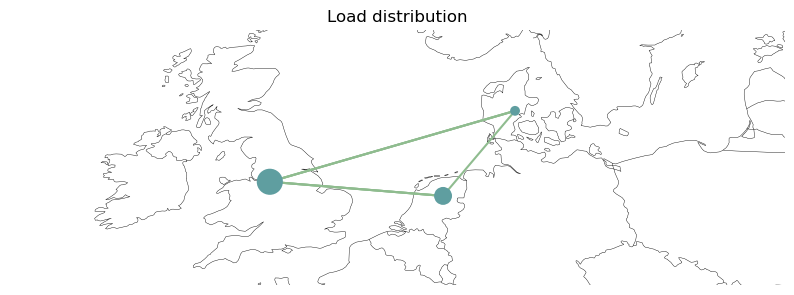

In [55]:
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(10, 10)
)

load_distribution = (
    n.loads_t.p_set.loc[n.snapshots[0]].groupby(n.loads.bus).sum()
)
n.plot(bus_sizes=0.5e-5 * load_distribution,margin= 1 ,ax=ax, title="Load distribution");

In [56]:
load_distribution

bus
DNK              3210.980000
GBR             29059.000000
NLD             11338.000000
heat bus DNK     9093.028295
heat bus GBR    64062.547877
heat bus NLD    30208.769643
Name: 2015-01-01 00:00:00+00:00, dtype: float64

In [57]:
n.generators_t.p["DNK offshorewind"].sum()
n.generators_t.p["DNK onshorewind"].sum()
n.generators_t.p["DNK solar"].sum()
n.generators_t.p["DNK nuclear"].sum()
n.generators_t.p["DNK CCGT"].sum()

3315532.5938173276

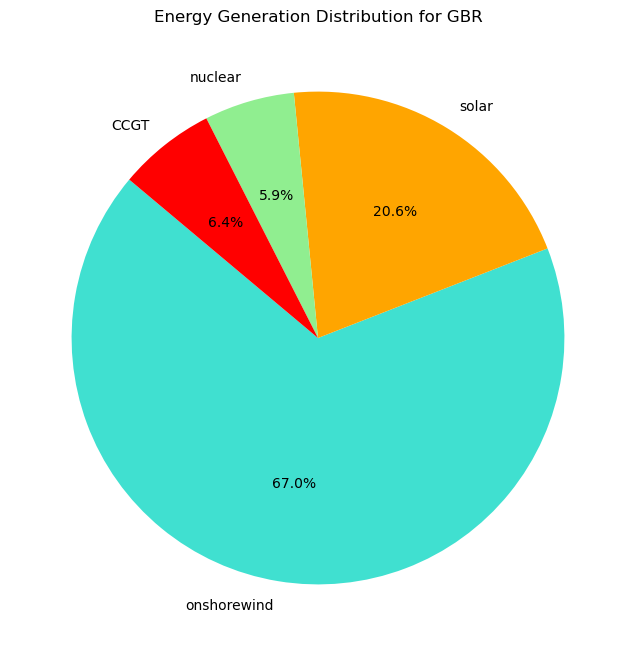

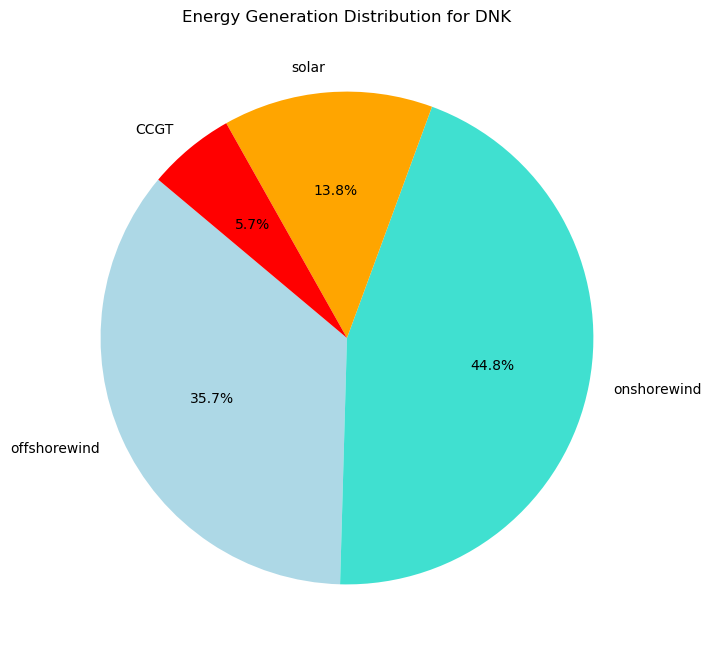

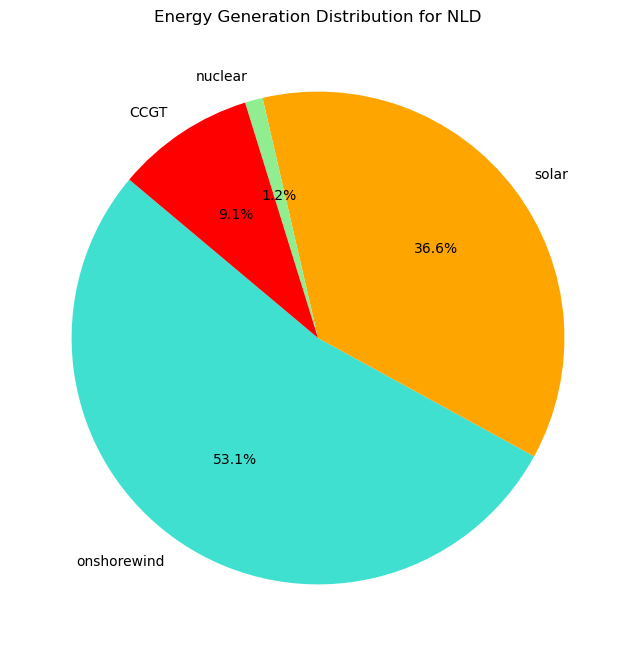

In [70]:
import matplotlib.pyplot as plt

# List of countries
countries = ['GBR', 'DNK', 'NLD']

# List of energy sources
energy_sources = ['offshorewind', 'onshorewind', 'solar', 'nuclear', 'CCGT']

# Colors for the pie chart
colors = ['lightblue', 'turquoise', 'orange', 'lightgreen', 'red']

# Loop through each country
for country in countries:
    # Calculate the generation sums for each energy source
    sizes = [n.generators_t.p[f"{country} {source}"].sum() for source in energy_sources]
    
    # Filter out sources with approximately zero contribution
    filtered_sizes = [size for size in sizes if size > 0]
    filtered_labels = [energy_sources[i] for i in range(len(sizes)) if sizes[i] > 0]
    filtered_colors = [colors[i] for i in range(len(sizes)) if sizes[i] > 0]
    
    # Create the pie chart
    if filtered_sizes:  # Only plot if there are non-zero contributions
        plt.figure(figsize=(8, 8))
        plt.pie(filtered_sizes, labels=filtered_labels, autopct='%1.1f%%', startangle=140, colors=filtered_colors)
        plt.title(f'Energy Generation Distribution for {country}')
        plt.show()

In [59]:
gen = n.generators.assign(g=n.generators_t.p.sum()).groupby(["bus", "carrier"]).g.sum();
gen

bus           carrier     
DNK                           3.282993e+05
              gas             3.315533e+06
              nuclear         0.000000e+00
              offshorewind    2.060816e+07
              onshorewind     2.590808e+07
              solar           7.950018e+06
GBR                           3.486048e+05
              gas             3.252632e+07
              nuclear         3.009215e+07
              offshorewind    0.000000e+00
              onshorewind     3.405964e+08
              solar           1.048902e+08
NLD                           3.856700e+05
              gas             1.678639e+07
              nuclear         2.160911e+06
              offshorewind    0.000000e+00
              onshorewind     9.796835e+07
              solar           6.745583e+07
heat bus DNK  gas             1.000000e+03
heat bus GBR  gas             1.000000e+03
heat bus NLD  gas             1.000000e+03
Name: g, dtype: float64

In [46]:
n.carriers

attribute,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
gas,0.19,,,inf,0.0
onshorewind,0.00,,,inf,0.0
offshorewind,0.00,,,inf,0.0
nuclear,0.00,,,inf,0.0
solar,0.00,,,inf,0.0
heat,0.00,,,inf,0.0
H2,0.00,,,inf,0.0


In [47]:
gen["DNK"]

carrier
                3.282993e+05
gas             3.315533e+06
nuclear         0.000000e+00
offshorewind    2.060816e+07
onshorewind     2.590808e+07
solar           7.950018e+06
Name: g, dtype: float64

In [48]:
gen.groupby(level=0).sum()

bus
DNK             5.811009e+07
GBR             5.084537e+08
NLD             1.847571e+08
heat bus DNK    1.000000e+03
heat bus GBR    1.000000e+03
heat bus NLD    1.000000e+03
Name: g, dtype: float64

In [49]:
gen.groupby(level=1).sum()

carrier
                1.062574e+06
gas             5.263125e+07
nuclear         3.225306e+07
offshorewind    2.060816e+07
onshorewind     4.644729e+08
solar           1.802961e+08
Name: g, dtype: float64

In [50]:
n.statistics()

Capacity Factor  Capital Expenditure   Curtailment  \
          carrier                                                            
Generator -                    0.404328         0.000000e+00  0.000000e+00   
          gas                  0.114620         4.198716e+09  0.000000e+00   
          nuclear              0.495795         6.179948e+09  0.000000e+00   
          offshorewind         0.384677         1.513472e+09  3.832419e+06   
          onshorewind          0.227276         2.886748e+10  6.070562e+07   
          solar                0.108507         1.052834e+10  2.463949e+05   
Link      H2                   0.190790         4.974394e+09           NaN   
          electricity          0.333996         3.810633e+09           NaN   
          heat                      NaN         0.000000e+00           NaN   
Load      -                         NaN                  NaN           NaN   
          H2                        NaN                  NaN           NaN   
Store     H2                   0.482566         3.974125e+09           NaN   

                            Dispatch  Installed Capacity  Market Value  \
          carrier                                                        
Generator -             1.062574e+06               300.0  2.540912e+02   
          gas           5.263125e+07              3000.0  3.690331e+02   
          nuclear       3.225306e+07                 0.0  2.117350e+02   
          offshorewind  2.060816e+07                 0.0  7.344043e+01   
          onshorewind   4.644729e+08                 0.0  6.215106e+01   
          solar         1.802961e+08                 0.0  5.839475e+01   
Link      H2           -1.640475e+08                 0.0 -3.032288e+01   
          electricity  -4.283002e+08                 0.0 -8.897109e+00   
          heat          0.000000e+00                 0.0           NaN   
Load      -            -1.067712e+09                 NaN -7.510470e+01   
          H2            0.000000e+00                 NaN           NaN   
Store     H2           -5.235779e-08                 0.0 -5.847961e+16   

                        Operational Expenditure  Optimal Capacity  \
          carrier                                                   
Generator -                        5.312871e+07      3.000000e+02   
          gas                      3.191437e+09      5.241767e+04   
          nuclear                  6.059666e+08      7.426169e+03   
          offshorewind             0.000000e+00      6.115593e+03   
          onshorewind              0.000000e+00      2.332937e+05   
          solar                    0.000000e+00      1.896805e+05   
Link      H2                       0.000000e+00      9.815440e+04   
          electricity              0.000000e+00      1.515352e+05   
          heat                     0.000000e+00      0.000000e+00   
Load      -                                 NaN               NaN   
          H2                                NaN               NaN   
Store     H2                       0.000000e+00      5.453440e+06   

                             Revenue        Supply    Withdrawal  
          carrier                                                 
Generator -             2.699907e+08  1.062574e+06  0.000000e+00  
          gas           1.942267e+10  5.263125e+07  0.000000e+00  
          nuclear       6.829101e+09  3.225306e+07  0.000000e+00  
          offshorewind  1.513472e+09  2.060816e+07  0.000000e+00  
          onshorewind   2.886748e+10  4.644729e+08  0.000000e+00  
          solar         1.052834e+10  1.802961e+08  0.000000e+00  
Link      H2            4.974394e+09  9.514757e+07 -1.640475e+08  
          electricity   3.810633e+09  8.286505e+08 -4.433622e+08  
          heat          0.000000e+00  0.000000e+00  0.000000e+00  
Load      -             8.019021e+10  0.000000e+00 -1.067712e+09  
          H2            0.000000e+00  0.000000e+00  0.000000e+00  
Store     H2            3.974125e+09  1.629180e+08 -1.62

In [51]:
n.consistency_check()

<Axes: xlabel='snapshot', ylabel='demand'>

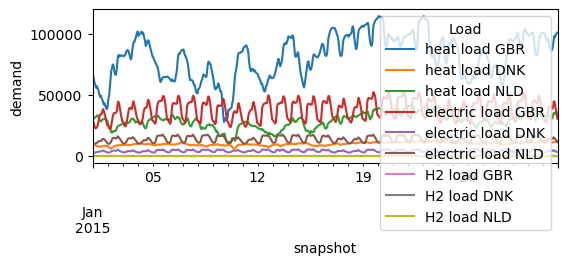

In [52]:

n.loads_t.p.loc["2015-01"].plot(figsize=(6, 2), ylabel="demand")

In [53]:
n.loads_t.p_set

Load,electric load DNK,electric load GBR,electric load NLD,heat load DNK,heat load GBR,heat load NLD
snapshot,,,,,,
2015-01-01 00:00:00+00:00,3210.98,29059.0,11338.0,9093.028295,64062.547877,30208.769643
2015-01-01 01:00:00+00:00,3100.02,28663.0,10917.0,9162.106574,65383.397149,30178.483595
2015-01-01 02:00:00+00:00,2980.39,26626.0,10473.0,9041.271380,62689.532460,30656.801254
2015-01-01 03:00:00+00:00,2933.49,24778.0,10200.0,8929.419452,60457.750833,31221.195229
2015-01-01 04:00:00+00:00,2941.54,23212.0,10182.0,8784.376068,58777.369771,31682.524876
...,...,...,...,...,...,...
2015-12-31 19:00:00+00:00,3687.87,35944.0,12958.0,9190.317702,71894.596165,23569.329326
2015-12-31 20:00:00+00:00,3535.55,33128.0,12263.0,9059.089753,75222.772139,23954.753254
2015-12-31 21:00:00+00:00,3389.26,30488.0,11772.0,8940.332320,78960.353024,24256.040638


In [54]:
n.buses.index.tolist()

['GBR',
 'DNK',
 'NLD',
 'heat bus GBR',
 'heat bus DNK',
 'heat bus NLD',
 'H2 bus GBR',
 'H2 bus DNK',
 'H2 bus NLD']

In [64]:
n.generators.assign(g=n.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum()

bus           carrier     
DNK                              37.477090
              gas               378.485456
              nuclear             0.000000
              offshorewind     2352.529311
              onshorewind      2957.543795
              solar             907.536289
GBR                              39.795071
              gas              3713.050261
              nuclear          3435.177029
              offshorewind        0.000000
              onshorewind     38880.870570
              solar           11973.768138
NLD                              44.026260
              gas              1916.254878
              nuclear           246.679374
              offshorewind        0.000000
              onshorewind     11183.601255
              solar            7700.436895
heat bus DNK  gas                 0.114155
heat bus GBR  gas                 0.114155
heat bus NLD  gas                 0.114155
Name: g, dtype: float64

In [63]:
n.links_t.p0.mean().abs()

Link
GBR heat pump                  17007.293980
DNK heat pump                   2043.330567
NLD heat pump                   5281.578362
GBR H2 Electrolysis            14976.270061
DNK H2 Electrolysis             1601.845852
NLD H2 Electrolysis             6830.493189
GBR H2 Fuel Cell               11981.016049
DNK H2 Fuel Cell                1281.476681
NLD H2 Fuel Cell                5464.394551
GBR - DNK                        372.111712
GBR - NLD                        421.911953
DNK - NLD                        357.880247
heat bus GBR - heat bus DNK        0.000000
heat bus GBR - heat bus NLD        0.000000
H2 bus GBR - H2 bus DNK            0.000000
H2 bus GBR - H2 bus NLD            0.000000
dtype: float64

<Axes: xlabel='snapshot', ylabel='H2 Electrolysis'>

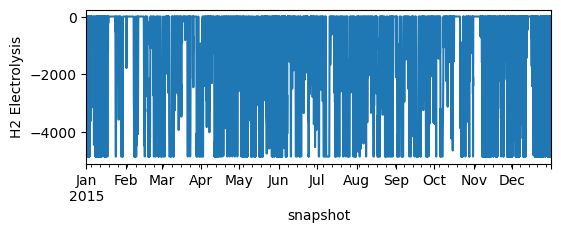

In [122]:
n.links_t.p1["DNK H2 Electrolysis"].plot(figsize=(6, 2), ylabel="H2 Electrolysis")  

<Axes: xlabel='snapshot', ylabel='H2 Electrolysis'>

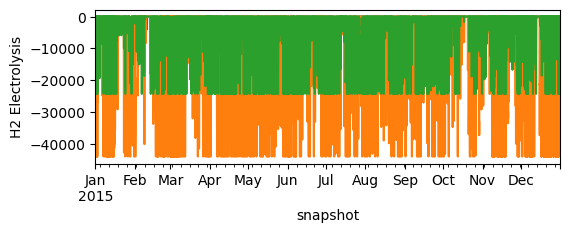

In [123]:
"Hydrogen Production in Each Country";
n.links_t.p1["DNK H2 Electrolysis"].plot(figsize=(6, 2), ylabel="H2 Electrolysis")   
n.links_t.p1["GBR H2 Electrolysis"].plot(figsize=(6, 2), ylabel="H2 Electrolysis")
n.links_t.p1["NLD H2 Electrolysis"].plot(figsize=(6, 2), ylabel="H2 Electrolysis")

In [121]:
-n.links_t.p1["DNK H2 Electrolysis"].loc["2015-01"].tail()

snapshot
2015-01-31 19:00:00+00:00    0.0
2015-01-31 20:00:00+00:00    0.0
2015-01-31 21:00:00+00:00    0.0
2015-01-31 22:00:00+00:00    0.0
2015-01-31 23:00:00+00:00    0.0
Freq: h, Name: DNK H2 Electrolysis, dtype: float64

In [124]:
duration_electrolysis_DNK = -n.links_t.p1["DNK H2 Electrolysis"].sort_values(ascending=True)
duration_electrolysis_GBR = -n.links_t.p1["GBR H2 Electrolysis"].sort_values(ascending=True)
duration_electrolysis_NLD = -n.links_t.p1["NLD H2 Electrolysis"].sort_values(ascending=True)

In [125]:
duration_electrolysis_NLD

snapshot
2015-07-02 11:00:00+00:00    24254.509213
2015-09-29 12:00:00+00:00    24254.509213
2015-09-29 11:00:00+00:00    24254.509213
2015-09-29 10:00:00+00:00    24254.509213
2015-01-24 11:00:00+00:00    24254.509213
                                 ...     
2015-05-26 20:00:00+00:00        0.000000
2015-05-26 19:00:00+00:00        0.000000
2015-05-26 18:00:00+00:00        0.000000
2015-05-27 04:00:00+00:00        0.000000
2015-12-31 23:00:00+00:00        0.000000
Name: NLD H2 Electrolysis, Length: 8760, dtype: float64

In [126]:
n.generators_t.p["GBR gas generator"]

snapshot
2015-01-01 00:00:00+00:00    0.0
2015-01-01 01:00:00+00:00    0.0
2015-01-01 02:00:00+00:00    0.0
2015-01-01 03:00:00+00:00    0.0
2015-01-01 04:00:00+00:00    0.0
                            ... 
2015-12-31 19:00:00+00:00    0.0
2015-12-31 20:00:00+00:00    0.0
2015-12-31 21:00:00+00:00    0.0
2015-12-31 22:00:00+00:00    0.0
2015-12-31 23:00:00+00:00    0.0
Freq: h, Name: GBR gas generator, Length: 8760, dtype: float64

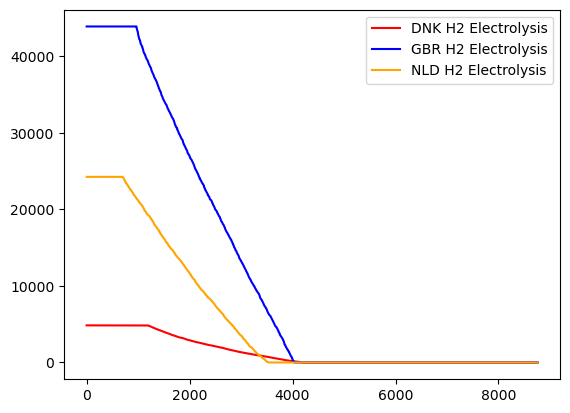

In [128]:
plt.plot(duration_electrolysis_DNK.values, label="DNK H2 Electrolysis", color='red')
plt.plot(duration_electrolysis_GBR.values, label="GBR H2 Electrolysis", color='blue')
plt.plot(duration_electrolysis_NLD.values, label="NLD H2 Electrolysis", color='orange')
plt.legend()